<a href="https://colab.research.google.com/github/aditidagar/ocular_disease_recog/blob/Adding-VGG16-model-Jupiter-files/MODEL/InceptionV3_N_C_M_A_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/amd/')
isConcat = False

Mounted at /amd/


Note:  
* edit the path to the dataset depending wehere it was saved. Aslo vgg16_weights_tf_dim_ordering_tf_kernels.h5 is avalible in the repo or you could download it by yourself.

*  vgg16_weights_tf_dim_ordering_tf_kernels.h5 should be used if it is impossible to get the weights in defining the keras.VGG16 model or for manually defined model.

In [ ]:
if isConcat:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_concat.zip /content/
    !unzip ODIR-5K_aug_contrast_concat.zip
else:
    !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_NOFUSION.zip /content/
    !unzip ODIR-5K_aug_contrast_NOFUSION.zip 
    # !cp /amd/My\ Drive/CSC490Data/ODIR-5K_aug_contrast_SUM.zip /content/
    # !unzip ODIR-5K_aug_contrast_SUM.zip

Most of the preparation work is taken from the Grzegors model.

Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData


In [ ]:
import os
import glob

items_to_remove = []
all_elements_train=0
all_elements_val = 0
for element in glob.glob("ODIR-5K/Training Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else:
    all_elements_train+=1
  
for element in glob.glob("ODIR-5K/Validation_Images/*.jpg"):
  img_name = element.split("/")[-1]
  img_label = img_name.split("-")
  if img_label[1] != "N.jpg" and img_label[1] != "C.jpg" and img_label[1] != "M.jpg" and img_label[1] != "A.jpg":
    items_to_remove.append(element)
  else: 
    all_elements_val+=1
  
for e in items_to_remove:
  os.remove(e)

print(all_elements_train, all_elements_val)

6832 968


In [ ]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_WIDTH = 250
if isConcat:
    IMG_WIDTH = 500
IMG_HEIGHT= 250
CLASS_NAMES = ['N', 'C', 'M', 'A']

In [ ]:
tf.random.set_seed(10) 

In [ ]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [ ]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'C':
        l[1] = 1
      elif e == 'M':
        l[2] = 1
      elif e == 'A':
        l[3] = 1
  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  N [1 0 0 0]
label:  C [0 1 0 0]
label:  A [0 0 0 1]
label:  M [0 0 1 0]


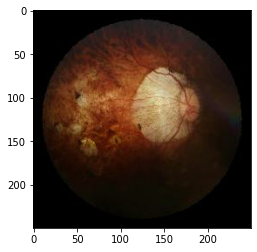

In [ ]:
for image, label in resampled_named_ds.take(6):
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [ ]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [ ]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=3000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

[0 0 0 1]


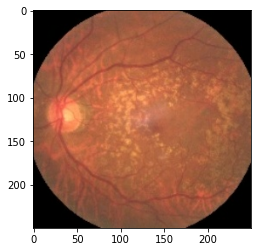

In [ ]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [ ]:
from tensorflow.keras.applications import InceptionV3
tf.random.set_seed(10) 
inception_v3 = InceptionV3(weights="imagenet",include_top = False,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))

In [ ]:
#  TODO : if time permits I need to play around with letting few layer to be editable again
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
model = Sequential()
model.add(inception_v3)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4,activation="sigmoid"))

In [ ]:

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint("inception3.h5",monitor="val_accuracy",verbose=1, save_best_only=True, save_weights_only=False, period=1)
# earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

In [ ]:
#  TODO : test with different optimizers such as SGD and Adam with different alphas
tf.random.set_seed(7) 
#  final accuracy 0.794
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True),loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.compile(optimizer="adam",loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 100356    
                                                                 
Total params: 14,815,044
Trainable params: 100,356
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(final_train_ds,
                    steps_per_epoch = 220,
                    epochs=15,
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    verbose=1,
                    callbacks=[checkpoint]
                    )

Epoch 1/15
220/220 [==============================] - ETA: 0s - loss: 0.2882 - accuracy: 0.7550 - precision_4: 0.7939 - recall_4: 0.6626
Epoch 00001: val_accuracy improved from -inf to 0.77462, saving model to vgg16.h5
220/220 [==============================] - 26s 99ms/step - loss: 0.2882 - accuracy: 0.7550 - precision_4: 0.7939 - recall_4: 0.6626 - val_loss: 0.2916 - val_accuracy: 0.7746 - val_precision_4: 0.7802 - val_recall_4: 0.6723
Epoch 2/15
220/220 [==============================] - ETA: 0s - loss: 0.1881 - accuracy: 0.8609 - precision_4: 0.8728 - recall_4: 0.8054
Epoch 00002: val_accuracy improved from 0.77462 to 0.86174, saving model to vgg16.h5
220/220 [==============================] - 22s 98ms/step - loss: 0.1881 - accuracy: 0.8609 - precision_4: 0.8728 - recall_4: 0.8054 - val_loss: 0.2136 - val_accuracy: 0.8617 - val_precision_4: 0.8330 - val_recall_4: 0.8598
Epoch 3/15
220/220 [==============================] - ETA: 0s - loss: 0.1539 - accuracy: 0.8966 - precision_4: 0.

below is result when doing the SGD optimizer. It gives smaller accuracy on 4 desceases but higher accuracy on all desceases. It is possbile that it needs smaller learning rate or more time to run.

In [ ]:
model.load_weights('vgg16.h5')
model.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 9s 89ms/step - loss: 0.2415 - accuracy: 0.8338 - precision_3: 0.8209 - recall_3: 0.7966


[0.24153991043567657,
 0.8337500095367432,
 0.820933997631073,
 0.7965624928474426]

below is result when doing the adam optimizer. It usually works better on the 4 desisases

In [ ]:
model.load_weights('vgg16.h5')
model.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 9s 89ms/step - loss: 0.2041 - accuracy: 0.8781 - precision_4: 0.8810 - recall_4: 0.8609


[0.2040998786687851, 0.878125011920929, 0.8810361623764038, 0.8609374761581421]

Below is the manual deffinition of the VGG16 model. This is an optional parts to run. And will od the same thing as done by keras.VGG16 model

In [ ]:
#  This is full vgg16 model
tf.random.set_seed(7) 
model_cnn_deep_jordi = tf.keras.Sequential()
# 1st VGG block
layer = tf.keras.layers.Conv2D(64, (3, 3), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3),activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#2nd VGG bloc
layer = tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#3nd VGG bloc
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(256, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#4nd VGG bloc
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


#5nd VGG bloc
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Conv2D(512, (3, 3), padding = "same", activation="relu")
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))
layer.trainable = False
model_cnn_deep_jordi.add(layer)


layer = tf.keras.layers.Flatten()
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(4096, activation='relu')
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(4096, activation='relu')
layer.trainable = False
model_cnn_deep_jordi.add(layer)
layer = tf.keras.layers.Dense(1000, activation='softmax')
layer.trainable = False
model_cnn_deep_jordi.add(layer)

model_cnn_deep_jordi.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels.h5")
model_cnn_deep_jordi.add(tf.keras.layers.Flatten()) # softmax or sigmoid
model_cnn_deep_jordi.add(tf.keras.layers.Dense(4, activation = 'sigmoid')) # softmax or sigmoid
# categorical_crossentropy  or binary_crossentropy
model_cnn_deep_jordi.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), # Adam(learning_rate=0.0001)
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn_deep_jordi.summary()

In [ ]:
#  Grzegorz model  https://github.com/GrzegorzMeller/AlgorithmsForMassiveData

model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(4, activation = 'sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model_cnn.summary()

In [ ]:
tf.random.set_seed(7) 
history_cnn = model_cnn.fit(final_train_ds,
                    #batch_size=32,
                    epochs=12,
                    steps_per_epoch = 200, #train_elements/batch_size
                    validation_data=final_test_ds,
                    validation_steps = 33,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    ) # TODO re-run this

Epoch 1/12
200/200 [==============================] - 128s 434ms/step - loss: 0.6251 - accuracy: 0.5362 - precision: 0.5287 - recall: 0.4541 - val_loss: 0.9629 - val_accuracy: 0.0710 - val_precision: 0.0710 - val_recall: 0.0710
Epoch 2/12
200/200 [==============================] - 85s 426ms/step - loss: 0.4161 - accuracy: 0.6631 - precision: 0.6710 - recall: 0.5969 - val_loss: 0.7086 - val_accuracy: 0.2500 - val_precision: 0.2470 - val_recall: 0.2348
Epoch 3/12
200/200 [==============================] - 85s 426ms/step - loss: 0.3669 - accuracy: 0.7195 - precision: 0.7158 - recall: 0.6517 - val_loss: 0.2928 - val_accuracy: 0.7898 - val_precision: 0.7960 - val_recall: 0.6837
Epoch 4/12
200/200 [==============================] - 85s 425ms/step - loss: 0.3349 - accuracy: 0.7397 - precision: 0.7392 - recall: 0.6750 - val_loss: 0.2900 - val_accuracy: 0.7983 - val_precision: 0.7345 - val_recall: 0.8097
Epoch 5/12
200/200 [==============================] - 85s 425ms/step - loss: 0.3095 - accur

In [ ]:
# tf.random.set_seed(35) 
# history_cnn_deep = model_cnn_deep_jordi.fit(final_train_ds,
#                     #batch_size=32,
#                     epochs=25, 
#                     steps_per_epoch = 213, #train_elements/batch_size
#                     validation_data=final_test_ds,
#                     validation_steps = 33,
#                     use_multiprocessing=True
#                     ) 

Epoch 1/25


In [ ]:
model_cnn.evaluate(final_test_ds, steps=100)

 43/100 [===========>..................] - ETA: 8s - loss: 0.7021 - accuracy: 0.0480 - precision_7: 0.0933 - recall_7: 0.2783

KeyboardInterrupt: ignored

In [ ]:
# model_cnn_deep_jordi.evaluate(final_test_ds, steps=100)

100/100 [==============================] - 22s 222ms/step - loss: 0.5240 - accuracy: 0.7850 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00


[0.5239885449409485, 0.7850000262260437, 0.0, 0.0]

# Clean up

In [ ]:
!rm -rf ODIR-5K_aug.zip
!rm -rf ODIR-5K/